# Fraud Detection
### By Keith D. Smith
### Data:  https://www.kaggle.com/datasets/kornilovag94/payment-systems-transactions-synthetic-dataset

This particular project presented a challenge as the dataset was highly imbalenced.  This is an instance of event detection where the event is high impact but low frequency.

## Import Packages and Data

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import classification_report
from tabulate import tabulate

In [10]:
df = pd.read_csv("fraud.csv", na_values=['NULL', '?', 'NONE'])

## EDA

In [11]:
df.shape

(6362620, 11)

In [12]:
df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [13]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [14]:
mapping = {0: 'Valid', 1: 'Fraudulent'}
df['Fraud'] = df['isFraud'].map(mapping)

In [15]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,Fraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,Valid
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,Valid
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,Fraudulent
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,Fraudulent
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,Valid


In [16]:
df.select_dtypes(exclude=['object']).describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [17]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

As is seen, there are over six million obsesrvations that were not fraudulent but just 8,213 observations that were fraudulent.  This is important because a model could prediction non-fradulent transactions for all observations and be extremely accurate.  Therefore, it is important to resample the data and then rely on metrics that accurately classify fraudulent behavior as fraudulent - sensitivity.

In [18]:
df = df.drop('step', axis=1)

In [19]:
df.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,Fraud
0,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,Valid
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,Valid
2,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,Fraudulent
3,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,Fraudulent
4,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,Valid


array([[<AxesSubplot:title={'center':'amount'}>,
        <AxesSubplot:title={'center':'oldbalanceOrg'}>],
       [<AxesSubplot:title={'center':'newbalanceOrig'}>,
        <AxesSubplot:title={'center':'oldbalanceDest'}>],
       [<AxesSubplot:title={'center':'newbalanceDest'}>, <AxesSubplot:>]],
      dtype=object)

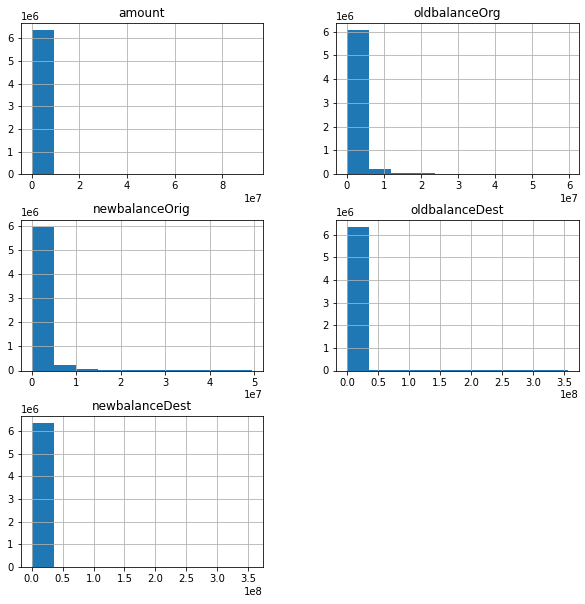

In [20]:
df.hist(['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'], figsize=(10, 10))

<BarContainer object of 2 artists>

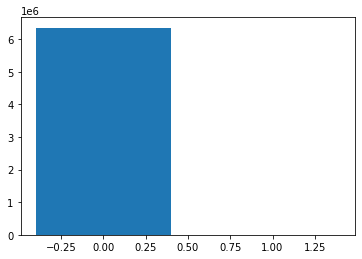

In [21]:
counts = df['isFraud'].value_counts()
plt.bar(counts.index, counts.values)

In [23]:
print(df.isnull().sum())

type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
Fraud             0
dtype: int64


<AxesSubplot:>

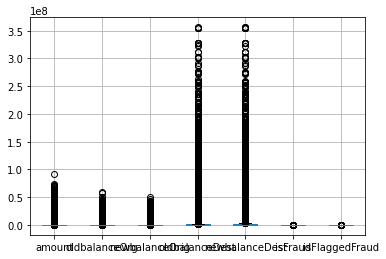

In [24]:
df.boxplot()

<ipython-input-22-ce189de096d9>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


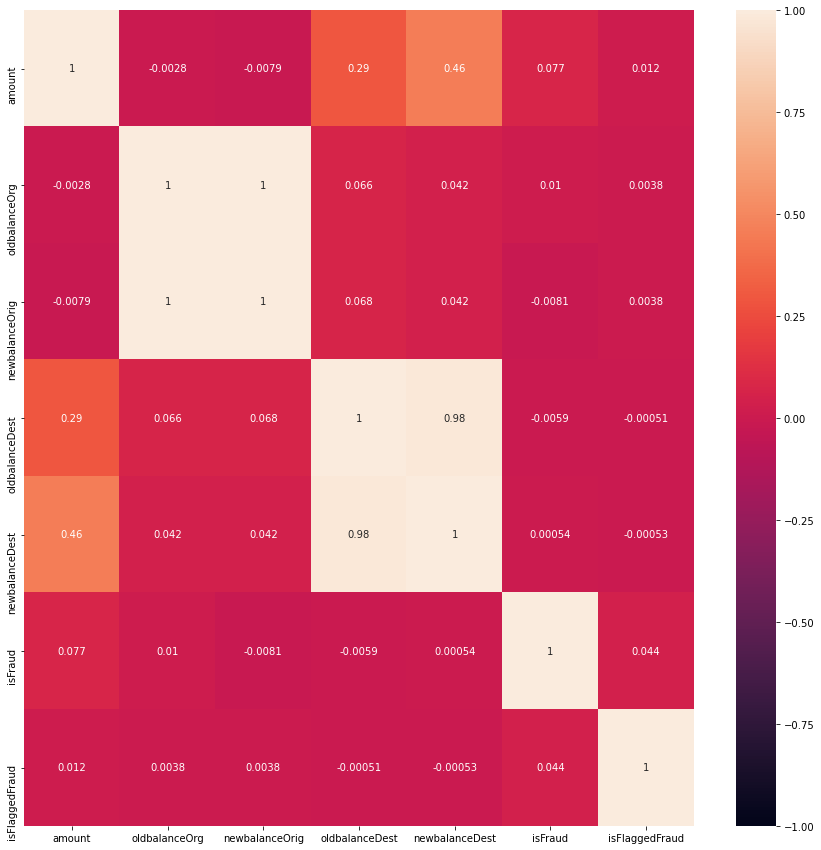

In [22]:
corr = df.corr()
plt.figure(figsize = (15, 15))
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True)

## Data Transformation

In [25]:
X = df.drop(['isFraud', 'Fraud'], axis=1)

In [26]:
y = df['isFraud']

In [29]:
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler(random_state = 42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

In [30]:
X = pd.get_dummies(X_resampled)

In [31]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

In [36]:
rfc.fit(X, y_resampled)

RandomForestClassifier(random_state=42)

In [37]:
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature Ranking")
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

Feature Ranking
1. oldbalanceOrg (0.202092)
2. amount (0.139332)
3. newbalanceOrig (0.093322)
4. type_TRANSFER (0.093238)
5. type_PAYMENT (0.080500)
6. newbalanceDest (0.050750)
7. oldbalanceDest (0.044317)
8. type_CASH_IN (0.039311)
9. type_CASH_OUT (0.027714)
10. type_DEBIT (0.000919)
11. isFlaggedFraud (0.000335)
12. nameOrig_C2125291409 (0.000141)
13. nameDest_C1460854172 (0.000134)
14. nameDest_C2127619327 (0.000130)
15. nameDest_C966173999 (0.000115)
16. nameDest_C200064275 (0.000114)
17. nameOrig_C1558811419 (0.000114)
18. nameOrig_C637927375 (0.000112)
19. nameOrig_C148430597 (0.000109)
20. nameOrig_C424344158 (0.000109)
21. nameOrig_C1415249262 (0.000108)
22. nameOrig_C236992376 (0.000105)
23. nameOrig_C1561310695 (0.000104)
24. nameDest_C152083725 (0.000103)
25. nameOrig_C1650136858 (0.000102)
26. nameOrig_C1311962270 (0.000101)
27. nameDest_C1143566273 (0.000101)
28. nameOrig_C361868064 (0.000100)
29. nameDest_C44368158 (0.000100)
30. nameOrig_C645124798 (0.000099)
31. nameD

2101. nameOrig_C428185794 (0.000028)
2102. nameOrig_C1669560481 (0.000028)
2103. nameOrig_C1737476949 (0.000028)
2104. nameOrig_C1464174863 (0.000028)
2105. nameOrig_C2037740348 (0.000028)
2106. nameDest_C1192656668 (0.000028)
2107. nameOrig_C950160827 (0.000028)
2108. nameOrig_C147918095 (0.000028)
2109. nameOrig_C2110170498 (0.000028)
2110. nameOrig_C1802633720 (0.000028)
2111. nameOrig_C1770262477 (0.000028)
2112. nameDest_C917335525 (0.000028)
2113. nameOrig_C1960830625 (0.000028)
2114. nameOrig_C520405565 (0.000028)
2115. nameOrig_C613702775 (0.000028)
2116. nameOrig_C1310278283 (0.000028)
2117. nameDest_C478545649 (0.000027)
2118. nameOrig_C1403929359 (0.000027)
2119. nameDest_C2124514895 (0.000027)
2120. nameOrig_C1091589527 (0.000027)
2121. nameOrig_C329603302 (0.000027)
2122. nameOrig_C259533000 (0.000027)
2123. nameDest_C418964192 (0.000027)
2124. nameOrig_C72843651 (0.000027)
2125. nameOrig_C1922440763 (0.000027)
2126. nameDest_C178533385 (0.000027)
2127. nameOrig_C200071029

4085. nameOrig_C406935284 (0.000017)
4086. nameOrig_C891040808 (0.000017)
4087. nameOrig_C1524282385 (0.000017)
4088. nameOrig_C1373058287 (0.000017)
4089. nameDest_C1265325259 (0.000017)
4090. nameOrig_C1915659563 (0.000017)
4091. nameDest_C2121024241 (0.000017)
4092. nameOrig_C216560481 (0.000017)
4093. nameDest_C1292490756 (0.000017)
4094. nameOrig_C1937012052 (0.000017)
4095. nameOrig_C1859886092 (0.000017)
4096. nameDest_C1729024666 (0.000017)
4097. nameOrig_C1241779064 (0.000017)
4098. nameOrig_C1700916573 (0.000017)
4099. nameDest_C1688264927 (0.000017)
4100. nameOrig_C1177564509 (0.000017)
4101. nameOrig_C600937906 (0.000017)
4102. nameDest_C730907439 (0.000017)
4103. nameOrig_C1345576574 (0.000017)
4104. nameDest_C1846130163 (0.000017)
4105. nameDest_C845050993 (0.000017)
4106. nameDest_C1959198865 (0.000017)
4107. nameDest_C1485457980 (0.000017)
4108. nameDest_C825667044 (0.000017)
4109. nameDest_C445816931 (0.000017)
4110. nameDest_C1846017772 (0.000017)
4111. nameDest_C1049

5969. nameDest_C870778014 (0.000012)
5970. nameDest_C1661087818 (0.000012)
5971. nameDest_C1119339680 (0.000012)
5972. nameDest_C467089211 (0.000012)
5973. nameDest_M458781549 (0.000012)
5974. nameOrig_C500524496 (0.000012)
5975. nameOrig_C1747133660 (0.000012)
5976. nameOrig_C738298142 (0.000012)
5977. nameDest_C56482072 (0.000012)
5978. nameDest_C1522114378 (0.000012)
5979. nameDest_M544707085 (0.000012)
5980. nameOrig_C569899403 (0.000012)
5981. nameOrig_C1178144946 (0.000012)
5982. nameDest_M340079645 (0.000012)
5983. nameOrig_C1683642176 (0.000012)
5984. nameDest_C1500998589 (0.000012)
5985. nameDest_M2089966333 (0.000012)
5986. nameDest_C2093453750 (0.000012)
5987. nameOrig_C1680914096 (0.000012)
5988. nameOrig_C871569877 (0.000012)
5989. nameOrig_C846698812 (0.000012)
5990. nameOrig_C756780016 (0.000012)
5991. nameDest_C575638324 (0.000012)
5992. nameOrig_C1837376093 (0.000012)
5993. nameDest_C1555319369 (0.000012)
5994. nameOrig_C834601814 (0.000012)
5995. nameOrig_C1945606464 

7514. nameDest_C33964619 (0.000009)
7515. nameDest_C2014938261 (0.000009)
7516. nameDest_C1311765185 (0.000009)
7517. nameDest_C809296702 (0.000009)
7518. nameOrig_C469202951 (0.000009)
7519. nameOrig_C1851369251 (0.000009)
7520. nameDest_C2087201290 (0.000009)
7521. nameOrig_C1765438191 (0.000009)
7522. nameOrig_C1695647811 (0.000009)
7523. nameDest_C1280060028 (0.000009)
7524. nameDest_C438270839 (0.000009)
7525. nameDest_C1225616405 (0.000009)
7526. nameDest_C149911894 (0.000009)
7527. nameOrig_C1536790025 (0.000009)
7528. nameOrig_C1143635966 (0.000009)
7529. nameDest_C599531619 (0.000009)
7530. nameOrig_C1747973387 (0.000009)
7531. nameDest_C1524019269 (0.000009)
7532. nameDest_C1562975084 (0.000009)
7533. nameOrig_C982480526 (0.000009)
7534. nameDest_C2004617547 (0.000009)
7535. nameDest_C708073508 (0.000009)
7536. nameDest_C214958057 (0.000009)
7537. nameOrig_C300451543 (0.000009)
7538. nameOrig_C1194657376 (0.000009)
7539. nameDest_M668780802 (0.000009)
7540. nameDest_C21111437

9233. nameDest_C57938337 (0.000006)
9234. nameDest_C174733068 (0.000006)
9235. nameDest_C1226867237 (0.000006)
9236. nameOrig_C1207800671 (0.000006)
9237. nameOrig_C1097979760 (0.000006)
9238. nameOrig_C743185292 (0.000006)
9239. nameOrig_C1724309679 (0.000006)
9240. nameDest_C975814766 (0.000006)
9241. nameOrig_C959095165 (0.000006)
9242. nameDest_C570708188 (0.000006)
9243. nameDest_C837253504 (0.000006)
9244. nameDest_C169982835 (0.000006)
9245. nameOrig_C348597707 (0.000006)
9246. nameDest_C301912677 (0.000006)
9247. nameOrig_C684857721 (0.000006)
9248. nameOrig_C80685681 (0.000006)
9249. nameDest_C290966672 (0.000006)
9250. nameOrig_C1766811336 (0.000006)
9251. nameOrig_C856680986 (0.000006)
9252. nameDest_C1849745670 (0.000006)
9253. nameDest_C353554883 (0.000006)
9254. nameOrig_C1845867430 (0.000006)
9255. nameOrig_C1857116353 (0.000006)
9256. nameOrig_C786979120 (0.000006)
9257. nameOrig_C238168336 (0.000006)
9258. nameDest_C399450397 (0.000006)
9259. nameDest_C1604176054 (0.00

11151. nameOrig_C1956745442 (0.000004)
11152. nameOrig_C1070172140 (0.000004)
11153. nameOrig_C355424107 (0.000004)
11154. nameOrig_C288028999 (0.000004)
11155. nameOrig_C1146494357 (0.000004)
11156. nameDest_C127980207 (0.000004)
11157. nameOrig_C105750198 (0.000004)
11158. nameOrig_C1229699193 (0.000004)
11159. nameDest_M1552518616 (0.000004)
11160. nameOrig_C475243362 (0.000004)
11161. nameOrig_C1517406520 (0.000004)
11162. nameOrig_C1990851012 (0.000004)
11163. nameDest_C1963510795 (0.000004)
11164. nameOrig_C1658688393 (0.000004)
11165. nameOrig_C87347257 (0.000004)
11166. nameDest_C2012581637 (0.000004)
11167. nameDest_M93670043 (0.000004)
11168. nameDest_C1937241264 (0.000004)
11169. nameDest_C276191877 (0.000004)
11170. nameDest_C1271955069 (0.000004)
11171. nameDest_C869351651 (0.000004)
11172. nameDest_C1798936808 (0.000004)
11173. nameOrig_C1056458251 (0.000004)
11174. nameDest_C1664276005 (0.000004)
11175. nameDest_C1133520647 (0.000004)
11176. nameOrig_C1501382387 (0.00000

12735. nameOrig_C66121649 (0.000004)
12736. nameOrig_C1267158518 (0.000004)
12737. nameDest_C516624765 (0.000004)
12738. nameDest_C43734927 (0.000004)
12739. nameDest_C1667231585 (0.000004)
12740. nameOrig_C803982089 (0.000004)
12741. nameDest_C1568275166 (0.000004)
12742. nameOrig_C1575335087 (0.000004)
12743. nameDest_M41638018 (0.000004)
12744. nameDest_C484785685 (0.000004)
12745. nameOrig_C968220575 (0.000004)
12746. nameDest_C1877485591 (0.000004)
12747. nameDest_C1945915435 (0.000004)
12748. nameOrig_C1576047062 (0.000004)
12749. nameDest_C1378236380 (0.000004)
12750. nameDest_M1386840519 (0.000004)
12751. nameOrig_C1969168470 (0.000004)
12752. nameDest_C1238721691 (0.000004)
12753. nameOrig_C922243256 (0.000004)
12754. nameOrig_C324016463 (0.000004)
12755. nameDest_M422789806 (0.000004)
12756. nameOrig_C1486866728 (0.000004)
12757. nameDest_M1286499631 (0.000004)
12758. nameOrig_C1500386109 (0.000004)
12759. nameOrig_C1014077257 (0.000004)
12760. nameOrig_C403276933 (0.000004)


14399. nameOrig_C217697661 (0.000003)
14400. nameDest_C295852822 (0.000003)
14401. nameOrig_C648547280 (0.000003)
14402. nameDest_C1761260133 (0.000003)
14403. nameDest_C1341894721 (0.000003)
14404. nameDest_C366782799 (0.000003)
14405. nameOrig_C1983397199 (0.000003)
14406. nameOrig_C931171461 (0.000003)
14407. nameOrig_C391142184 (0.000003)
14408. nameOrig_C1699499962 (0.000003)
14409. nameDest_C1970517993 (0.000003)
14410. nameOrig_C947691774 (0.000003)
14411. nameOrig_C884796861 (0.000003)
14412. nameDest_C953537068 (0.000003)
14413. nameDest_M1920471822 (0.000003)
14414. nameOrig_C644659506 (0.000003)
14415. nameOrig_C1139926828 (0.000003)
14416. nameOrig_C1254519154 (0.000003)
14417. nameOrig_C225886337 (0.000003)
14418. nameOrig_C2057725638 (0.000003)
14419. nameDest_C1815131206 (0.000003)
14420. nameDest_C2042858776 (0.000003)
14421. nameOrig_C2069185954 (0.000003)
14422. nameOrig_C1410879349 (0.000003)
14423. nameOrig_C587951461 (0.000003)
14424. nameOrig_C164780972 (0.000003)

16106. nameDest_C1354269038 (0.000002)
16107. nameOrig_C1558605799 (0.000002)
16108. nameOrig_C1555099712 (0.000002)
16109. nameOrig_C2011747129 (0.000002)
16110. nameOrig_C1805409130 (0.000002)
16111. nameOrig_C453571781 (0.000002)
16112. nameOrig_C1325240934 (0.000002)
16113. nameDest_M495052032 (0.000002)
16114. nameOrig_C2137465155 (0.000002)
16115. nameOrig_C1608113324 (0.000002)
16116. nameDest_C1687751044 (0.000002)
16117. nameDest_C1905611312 (0.000002)
16118. nameDest_C494891258 (0.000002)
16119. nameOrig_C908544136 (0.000002)
16120. nameOrig_C718213394 (0.000002)
16121. nameOrig_C872768364 (0.000002)
16122. nameDest_C1227889272 (0.000002)
16123. nameDest_C1313698236 (0.000002)
16124. nameOrig_C143562677 (0.000002)
16125. nameOrig_C902672806 (0.000002)
16126. nameDest_C860583556 (0.000002)
16127. nameOrig_C2032582234 (0.000002)
16128. nameOrig_C678293431 (0.000002)
16129. nameOrig_C1286267091 (0.000002)
16130. nameOrig_C1378980948 (0.000002)
16131. nameDest_C281172991 (0.00000

17596. nameOrig_C522510187 (0.000001)
17597. nameOrig_C1714764214 (0.000001)
17598. nameDest_C1680177404 (0.000001)
17599. nameDest_C1538735 (0.000001)
17600. nameDest_C1176091766 (0.000001)
17601. nameOrig_C869621048 (0.000001)
17602. nameOrig_C1740697509 (0.000001)
17603. nameDest_C408044151 (0.000001)
17604. nameDest_C1162455293 (0.000001)
17605. nameDest_C1883340818 (0.000001)
17606. nameOrig_C1160844097 (0.000001)
17607. nameOrig_C1295540356 (0.000001)
17608. nameDest_C87183368 (0.000001)
17609. nameDest_M960742840 (0.000001)
17610. nameOrig_C1759283871 (0.000001)
17611. nameDest_C882063580 (0.000001)
17612. nameOrig_C675089141 (0.000001)
17613. nameDest_C1428831661 (0.000001)
17614. nameOrig_C430668255 (0.000001)
17615. nameDest_M1726078410 (0.000001)
17616. nameOrig_C1896858408 (0.000001)
17617. nameOrig_C1822317411 (0.000001)
17618. nameOrig_C1270751664 (0.000001)
17619. nameOrig_C482687046 (0.000001)
17620. nameOrig_C1870187274 (0.000001)
17621. nameOrig_C949792674 (0.000001)


19301. nameOrig_C1729277361 (0.000000)
19302. nameDest_C961243143 (0.000000)
19303. nameDest_C461830129 (0.000000)
19304. nameDest_C422970659 (0.000000)
19305. nameOrig_C1802792293 (0.000000)
19306. nameDest_C675598051 (0.000000)
19307. nameDest_C1555994470 (0.000000)
19308. nameDest_M1344792579 (0.000000)
19309. nameDest_C1192284712 (0.000000)
19310. nameDest_C1774310379 (0.000000)
19311. nameOrig_C1071065975 (0.000000)
19312. nameOrig_C659661900 (0.000000)
19313. nameOrig_C1367101054 (0.000000)
19314. nameDest_M1106746700 (0.000000)
19315. nameDest_C559992116 (0.000000)
19316. nameOrig_C1446313443 (0.000000)
19317. nameDest_C675229754 (0.000000)
19318. nameDest_C870569313 (0.000000)
19319. nameDest_C1812152397 (0.000000)
19320. nameDest_C400200038 (0.000000)
19321. nameDest_C1982144545 (0.000000)
19322. nameDest_C1538319522 (0.000000)
19323. nameDest_C476657096 (0.000000)
19324. nameDest_C20386359 (0.000000)
19325. nameDest_C725953073 (0.000000)
19326. nameDest_C514505298 (0.000000)


21148. nameOrig_C84781239 (0.000000)
21149. nameOrig_C1517430908 (0.000000)
21150. nameOrig_C959100931 (0.000000)
21151. nameDest_C999470580 (0.000000)
21152. nameOrig_C470923235 (0.000000)
21153. nameDest_M1689236200 (0.000000)
21154. nameOrig_C967077917 (0.000000)
21155. nameDest_M827947695 (0.000000)
21156. nameDest_C1405637035 (0.000000)
21157. nameOrig_C211383098 (0.000000)
21158. nameDest_C1182308451 (0.000000)
21159. nameOrig_C1407135183 (0.000000)
21160. nameOrig_C1515227045 (0.000000)
21161. nameDest_C138172146 (0.000000)
21162. nameOrig_C1068111301 (0.000000)
21163. nameOrig_C97407183 (0.000000)
21164. nameOrig_C827650133 (0.000000)
21165. nameOrig_C956657254 (0.000000)
21166. nameDest_C960046463 (0.000000)
21167. nameDest_C1739928353 (0.000000)
21168. nameOrig_C802537858 (0.000000)
21169. nameDest_C1215950327 (0.000000)
21170. nameOrig_C470813600 (0.000000)
21171. nameOrig_C2088472224 (0.000000)
21172. nameDest_M2009302333 (0.000000)
21173. nameOrig_C2114695453 (0.000000)
21

23062. nameDest_C1681916503 (0.000000)
23063. nameDest_C1156197482 (0.000000)
23064. nameOrig_C936646245 (0.000000)
23065. nameDest_C357180483 (0.000000)
23066. nameDest_C1751510346 (0.000000)
23067. nameOrig_C578092794 (0.000000)
23068. nameDest_C2043561429 (0.000000)
23069. nameOrig_C997695120 (0.000000)
23070. nameDest_C1134558606 (0.000000)
23071. nameDest_C933704571 (0.000000)
23072. nameOrig_C1904629487 (0.000000)
23073. nameOrig_C1966259064 (0.000000)
23074. nameDest_C1496803713 (0.000000)
23075. nameDest_C844027977 (0.000000)
23076. nameOrig_C1169625105 (0.000000)
23077. nameDest_C1919442037 (0.000000)
23078. nameDest_C1954069781 (0.000000)
23079. nameDest_C1822077806 (0.000000)
23080. nameOrig_C1968269776 (0.000000)
23081. nameDest_C1137540009 (0.000000)
23082. nameDest_C2134357721 (0.000000)
23083. nameDest_C498618435 (0.000000)
23084. nameDest_C580058151 (0.000000)
23085. nameOrig_C2143862978 (0.000000)
23086. nameDest_C1908107274 (0.000000)
23087. nameOrig_C652805984 (0.000

24552. nameOrig_C1932973145 (0.000000)
24553. nameDest_M637819042 (0.000000)
24554. nameDest_C1230205848 (0.000000)
24555. nameDest_C1200267069 (0.000000)
24556. nameOrig_C1133621753 (0.000000)
24557. nameOrig_C856217790 (0.000000)
24558. nameOrig_C677179162 (0.000000)
24559. nameDest_C1768725891 (0.000000)
24560. nameOrig_C11425665 (0.000000)
24561. nameDest_C597468231 (0.000000)
24562. nameOrig_C313989858 (0.000000)
24563. nameOrig_C1998191223 (0.000000)
24564. nameOrig_C951821221 (0.000000)
24565. nameDest_C1027984317 (0.000000)
24566. nameOrig_C1164571434 (0.000000)
24567. nameOrig_C1483135498 (0.000000)
24568. nameOrig_C1112249638 (0.000000)
24569. nameOrig_C1905022556 (0.000000)
24570. nameOrig_C668285021 (0.000000)
24571. nameDest_C106857650 (0.000000)
24572. nameOrig_C1098392781 (0.000000)
24573. nameOrig_C461302689 (0.000000)
24574. nameOrig_C1115743451 (0.000000)
24575. nameOrig_C1770745234 (0.000000)
24576. nameOrig_C100399782 (0.000000)
24577. nameDest_C1466511502 (0.000000

27023. nameOrig_C1181245591 (0.000000)
27024. nameDest_C142613727 (0.000000)
27025. nameDest_C1191544932 (0.000000)
27026. nameOrig_C172382557 (0.000000)
27027. nameDest_C1722646807 (0.000000)
27028. nameOrig_C2089427736 (0.000000)
27029. nameDest_M1635644588 (0.000000)
27030. nameDest_C651955391 (0.000000)
27031. nameDest_C96603111 (0.000000)
27032. nameDest_C746452317 (0.000000)
27033. nameOrig_C51691923 (0.000000)
27034. nameDest_M1341048213 (0.000000)
27035. nameOrig_C195008073 (0.000000)
27036. nameDest_C268435937 (0.000000)
27037. nameOrig_C664375770 (0.000000)
27038. nameDest_C97544246 (0.000000)
27039. nameDest_C1888923091 (0.000000)
27040. nameOrig_C41154667 (0.000000)
27041. nameOrig_C1809626862 (0.000000)
27042. nameOrig_C169061648 (0.000000)
27043. nameDest_C1076792770 (0.000000)
27044. nameDest_C1204122756 (0.000000)
27045. nameOrig_C476581036 (0.000000)
27046. nameDest_C32152023 (0.000000)
27047. nameDest_C1470544838 (0.000000)
27048. nameDest_C917502262 (0.000000)
27049.

29191. nameDest_M2032870822 (0.000000)
29192. nameOrig_C1953199729 (0.000000)
29193. nameDest_C421189395 (0.000000)
29194. nameOrig_C1013385845 (0.000000)
29195. nameDest_C1639044833 (0.000000)
29196. nameOrig_C2061405959 (0.000000)
29197. nameDest_C1058239852 (0.000000)
29198. nameDest_C42065364 (0.000000)
29199. nameDest_M94286603 (0.000000)
29200. nameDest_M940450671 (0.000000)
29201. nameDest_M940387582 (0.000000)
29202. nameDest_C1639504554 (0.000000)
29203. nameDest_M940291305 (0.000000)
29204. nameDest_C1394440708 (0.000000)
29205. nameDest_C1642306592 (0.000000)
29206. nameDest_M970109706 (0.000000)
29207. nameDest_M2037781941 (0.000000)
29208. nameOrig_C1263150351 (0.000000)
29209. nameOrig_C1000125073 (0.000000)
29210. nameOrig_C1268829282 (0.000000)
29211. nameDest_C1653555821 (0.000000)
29212. nameDest_C1653110948 (0.000000)
29213. nameOrig_C1268743025 (0.000000)
29214. nameOrig_C1947157402 (0.000000)
29215. nameOrig_C252152925 (0.000000)
29216. nameDest_C428725863 (0.00000

30679. nameOrig_C1848562108 (0.000000)
30680. nameDest_C722968916 (0.000000)
30681. nameOrig_C460040763 (0.000000)
30682. nameDest_M1227509570 (0.000000)
30683. nameOrig_C460572738 (0.000000)
30684. nameOrig_C461226814 (0.000000)
30685. nameOrig_C828866068 (0.000000)
30686. nameDest_M1226737375 (0.000000)
30687. nameOrig_C83063124 (0.000000)
30688. nameOrig_C830772393 (0.000000)
30689. nameDest_C720812883 (0.000000)
30690. nameOrig_C149881644 (0.000000)
30691. nameOrig_C1498028072 (0.000000)
30692. nameDest_C1831256584 (0.000000)
30693. nameDest_C1831477404 (0.000000)
30694. nameDest_M1248438673 (0.000000)
30695. nameDest_C241558961 (0.000000)
30696. nameOrig_C149862932 (0.000000)
30697. nameOrig_C1498875416 (0.000000)
30698. nameOrig_C459536801 (0.000000)
30699. nameDest_M1246232113 (0.000000)
30700. nameOrig_C831891422 (0.000000)
30701. nameDest_C1833323535 (0.000000)
30702. nameDest_M1243173240 (0.000000)
30703. nameOrig_C149938639 (0.000000)
30704. nameOrig_C459414778 (0.000000)
30

In [38]:
sum(importances)

0.9999999999999991

In [39]:
X = X_resampled[['oldbalanceOrg', 'amount', 'newbalanceOrig', 'newbalanceDest']]
y = y_resampled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Predictive Analysis

### KNN

In [40]:
knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
knn.fit(X_train, y_train.values.ravel())
y_pred_knn = knn.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred_knn)
tn, fp, fn, tp = cm.ravel()
sensitivity_knn = tp / (tp + fn)
cr = classification_report(y_test, y_pred_knn)
print("Confusion matrix:\n", cm)
print("Classification report:\n", cr)
print("Sensitivity:", sensitivity_knn)

Confusion matrix:
 [[1579   70]
 [  55 1582]]
Classification report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96      1649
           1       0.96      0.97      0.96      1637

    accuracy                           0.96      3286
   macro avg       0.96      0.96      0.96      3286
weighted avg       0.96      0.96      0.96      3286

Sensitivity: 0.9664019547953574


### Naive Bayes

In [41]:
nb = GaussianNB()
nb.fit(X_train, y_train.values.ravel())
y_pred_nb = nb.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred_nb)
tn, fp, fn, tp = cm.ravel()
sensitivity_nb = tp / (tp + fn)
cr = classification_report(y_test, y_pred_nb)
print("Confusion matrix:\n", cm)
print("Classification report:\n", cr)
print("Sensitivity:", sensitivity_nb)

Confusion matrix:
 [[1599   50]
 [1049  588]]
Classification report:
               precision    recall  f1-score   support

           0       0.60      0.97      0.74      1649
           1       0.92      0.36      0.52      1637

    accuracy                           0.67      3286
   macro avg       0.76      0.66      0.63      3286
weighted avg       0.76      0.67      0.63      3286

Sensitivity: 0.3591936469150886


### Decision Tree

In [42]:
dtree = DecisionTreeClassifier(criterion='entropy',random_state = 42)
dtree.fit(X_train,y_train)
y_pred_dt = nb.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred_dt)
tn, fp, fn, tp = cm.ravel()
sensitivity_dt = tp / (tp + fn)
cr = classification_report(y_test, y_pred_dt)
print("Confusion matrix:\n", cm)
print("Classification report:\n", cr)
print("Sensitivity:", sensitivity_dt)

Confusion matrix:
 [[1599   50]
 [1049  588]]
Classification report:
               precision    recall  f1-score   support

           0       0.60      0.97      0.74      1649
           1       0.92      0.36      0.52      1637

    accuracy                           0.67      3286
   macro avg       0.76      0.66      0.63      3286
weighted avg       0.76      0.67      0.63      3286

Sensitivity: 0.3591936469150886


### Random Forrest

In [43]:
rfc_mod = RandomForestClassifier(n_estimators=10, random_state = 42)
rfc_mod.fit(X_train, y_train.values.ravel())
y_pred_rfc = rfc_mod.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred_rfc)
tn, fp, fn, tp = cm.ravel()
sensitivity_rfc = tp / (tp + fn)
cr = classification_report(y_test, y_pred_rfc)
print("Confusion matrix:\n", cm)
print("Classification report:\n", cr)
print("Sensitivity:", sensitivity_rfc)

Confusion matrix:
 [[1628   21]
 [   6 1631]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      1649
           1       0.99      1.00      0.99      1637

    accuracy                           0.99      3286
   macro avg       0.99      0.99      0.99      3286
weighted avg       0.99      0.99      0.99      3286

Sensitivity: 0.996334758704948


### XG Boost

In [44]:
xg= xgb.XGBClassifier(objective='binary:logistic', eval_metric='aucpr',use_label_encoder=False, random_state = 42)
xg.fit(X_train, y_train.values.ravel())
y_pred_xg = xg.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred_xg)
tn, fp, fn, tp = cm.ravel()
sensitivity_xg = tp / (tp + fn)
cr = classification_report(y_test, y_pred_xg)
print("Confusion matrix:\n", cm)
print("Classification report:\n", cr)
print("Sensitivity:", sensitivity_xg)

C:\Users\ksmith\Anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Confusion matrix:
 [[1629   20]
 [   5 1632]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      1649
           1       0.99      1.00      0.99      1637

    accuracy                           0.99      3286
   macro avg       0.99      0.99      0.99      3286
weighted avg       0.99      0.99      0.99      3286

Sensitivity: 0.9969456322541234


### Model Comparison

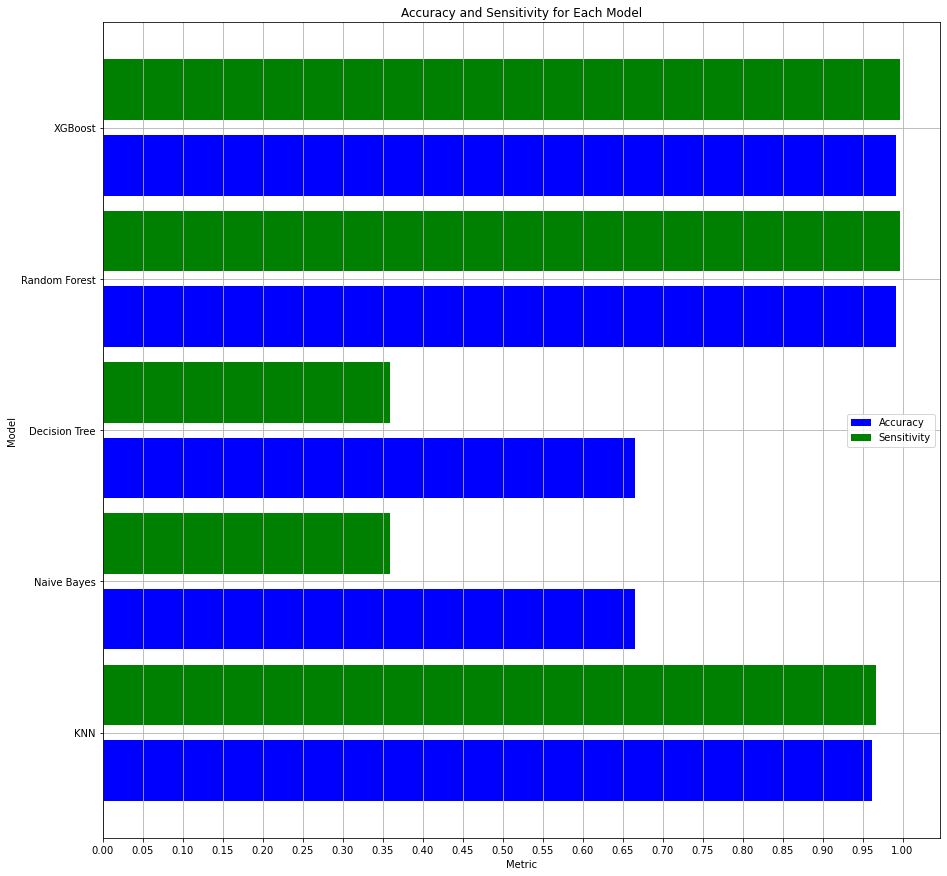

In [45]:
KNN_Accuracy = sum(y_pred_knn == y_test) / len(y_test)
Naive_Bayes_Accuracy = sum(y_pred_nb == y_test) / len(y_test)
Decision_Tree_Accuracy = sum(y_pred_dt == y_test) / len(y_test)
Random_Forest_Accuracy = sum(y_pred_rfc == y_test) / len(y_test)
XGBoost_Accuracy = sum(y_pred_xg == y_test) / len(y_test)

accuracies = [KNN_Accuracy, Naive_Bayes_Accuracy, Decision_Tree_Accuracy,Random_Forest_Accuracy, XGBoost_Accuracy]
sensitivities = [sensitivity_knn, sensitivity_nb, sensitivity_dt, sensitivity_rfc,sensitivity_xg]
model_names = ['KNN', 'Naive Bayes', 'Decision Tree', 'Random Forest', 'XGBoost']

bar_width = 0.4
space = 0.1
bar_positions = np.arange(len(model_names))
fig, ax = plt.subplots(figsize=(15, 15))
ax.barh(bar_positions, accuracies, label='Accuracy', color='blue',height=bar_width)
ax.barh(bar_positions + bar_width + space, sensitivities, label='Sensitivity', color='green', height=bar_width)
ax.set_xlabel('Metric')
ax.set_ylabel('Model')
ax.set_title('Accuracy and Sensitivity for Each Model')
ax.set_yticks(bar_positions + bar_width / 2 + space / 2)
ax.set_yticklabels(model_names)
ax.set_xticks(np.arange(0, 1.05, 0.05))
ax.legend()
ax.grid(True)
plt.show()